# US Immigration Analysis

### Project Summary
The goal of this project is to analyze the distribution of the immigrants arrive at US.

#### Scope 
For the project use the following tools:
- Spark and pandas for data handling
- Matplotlib for vizualization

### Datasets
The project use the following datasets

- **I94 Immigration Data**: This dataset contains international visitor arrival statistics by world regions and select countries (including top 20), type of visa, mode of transportation, age groups, states visited (first intended address only), and the top ports of entry (for select countries). <br>
- **U.S. City Demographic Data**: This dataset contains information about the demographics of all US cities and census-designated places with a population greater or equal to 65,000. <br>
- **Airport Code Table**: The airport codes may refer to either IATA airport code, a three-letter code which is used in passenger reservation, ticketing and baggage-handling systems, or the ICAO airport code which is a four letter code used by ATC systems and for airports that do not have an IATA airport code (from wikipedia).
- **Dictionaries**: Contains the lables for the ids in the U.S. City Demographic Data. 

In [70]:
# Load librarie
import pyspark
from pyspark.sql.functions import expr, isnan, when, count, col

# Initiate Spark Session
spark = pyspark\
        .sql\
        .SparkSession\
        .builder\
        .config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
        .enableHiveSupport()\
        .getOrCreate()

# Read parquet data
imm = spark.read.parquet("data_source/sas_data")

# Read csv data
air = spark.read.csv("data_source/airport-codes_csv.csv", header=True)
cit = spark.read.csv("data_source/us-cities-demographics.csv", sep=";", header=True)

# Read dictionaries
i94addr = spark.read.csv("data_source/i94addr.csv", sep=";", header=True)
i94mode = spark.read.csv("data_source/i94mode.csv", sep=";", header=True)
i94port = spark.read.csv("data_source/i94port.csv", sep=";", header=True)
i94visa = spark.read.csv("data_source/i94visa.csv", sep=";", header=True)
i94city = spark.read.csv("data_source/i94city.csv", sep=";", header=True)

### Data Exploration
For the goal of the project, the focus is on the data related to the:
- People arriving at US.
    - Quantity
    - Dates
    - Transport Type
    - Location
    - Visa Type
<br>
<br>
- Information about the cities
    - State
    - City
    - Population

In [2]:
imm.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [3]:
air.printSchema()

root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)



In [4]:
cit.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: string (nullable = true)
 |-- Male Population: string (nullable = true)
 |-- Female Population: string (nullable = true)
 |-- Total Population: string (nullable = true)
 |-- Number of Veterans: string (nullable = true)
 |-- Foreign-born: string (nullable = true)
 |-- Average Household Size: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: string (nullable = true)



### Check for Missing Values

Check any missing values in the Immigration table

In [32]:
imm.select([count(when(isnan(c), c)).alias(c) for c in imm.columns]).show()

+-----+-----+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+-------+------+------+-------+------+-----+--------+
|cicid|i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear|dtaddto|gender|insnum|airline|admnum|fltno|visatype|
+-----+-----+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+-------+------+------+-------+------+-----+--------+
|    0|    0|     0|     0|     0|      0|      0|      0|      0|      0|     0|      0|    0|       0|       0|    0|      0|      0|      0|      0|      0|      0|     0|     0|      0|     0|    0|       0|
+-----+-----+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-

Remove rows with the values of the column i94addr are not in U.S. state list

In [71]:
state = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "DC", "FL", "GA", "GU", "HI", "ID", "IL", "IN", "IA", "KS",
         "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NC", "ND", "NE", "NV", "NH", "NJ", "NM", "NY",
         "OH", "OK", "OR", "PA", "PR", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VI", "VA", "WV", "WA", "WI", "WY"]

imm = imm.where(col("i94addr").isin(state))

Convert date coluns to correct format

In [72]:
# Converting columns
imm = imm.withColumn('arrdate', expr("date_add(to_date('1960-01-01'),arrdate)"))
imm = imm.withColumn('depdate', expr("date_add(to_date('1960-01-01'),depdate)"))

### Data Model
#### Star Schema
For the project it will be used the star schema, the star schema consists of one or more fact tables referencing any number of dimension tables.

Dimension Tables
- Aiport Codes Data
- US Cities Data
- i94addr (dictionary)
- i94city (dictionary)
- i94mode (dictionary)
- i94mode (dictionary)
- i94visa (dictionary)

Fact Tables
- Immigration Data

### Pipelines
#### Pipeline Immigration Distribuition
The pipeline below is used for the analysis of the distributions of the immigrants

In [77]:
# Merge the tables
pipe = imm.join(i94addr,  ["i94addr"], how="left")
pipe = pipe.join(i94mode, ["i94mode"], how="left")
pipe = pipe.join(i94port, ["i94port"], how="left")
pipe = pipe.join(i94visa, ["i94visa"], how="left")
pipe = pipe.join(i94city, ["i94cit"], how="left")

# Group by State
pipe = pipe.groupby(["arrdate", "i94addr", "State"]).agg({"count": "count"})

# # Filter to print sample of data
pipe.filter(pipe.arrdate == "2016-04-30").show()

+----------+-------+-----------------+------------+
|   arrdate|i94addr|            State|count(count)|
+----------+-------+-----------------+------------+
|2016-04-30|     MT|          MONTANA|          65|
|2016-04-30|     NH|    NEW HAMPSHIRE|          93|
|2016-04-30|     SD|        S. DAKOTA|          29|
|2016-04-30|     FL|          FLORIDA|       25852|
|2016-04-30|     MD|         MARYLAND|         884|
|2016-04-30|     KS|           KANSAS|          76|
|2016-04-30|     VA|         VIRGINIA|        1222|
|2016-04-30|     ND|        N. DAKOTA|          55|
|2016-04-30|     NM|       NEW MEXICO|         110|
|2016-04-30|     WV|      W. VIRGINIA|          42|
|2016-04-30|     GA|          GEORGIA|        1570|
|2016-04-30|     DC|DIST. OF COLUMBIA|        1185|
|2016-04-30|     ME|            MAINE|          83|
|2016-04-30|     NJ|       NEW JERSEY|        2999|
|2016-04-30|     IN|          INDIANA|         406|
|2016-04-30|     CA|       CALIFORNIA|       19425|
|2016-04-30|

#### 4.2 Data Quality Checks
 
Run Quality Checks to garanty the dataframe is not null

In [103]:
# Perform quality checks here
print((pipe.count(), len(pipe.columns)))

(1620, 4)


#### 4.3 Data dictionary 

Below the description to each column of the pipeline

- arrdate: correspond to the arrive date of the passenger in U.S.
- i94addr: abbreviation state
- state: the state were the passenger arrive
- count: the number of passenger in the state and date

#### 4.4 Visualization

Below a sample of visualization for the date 04/30/2016

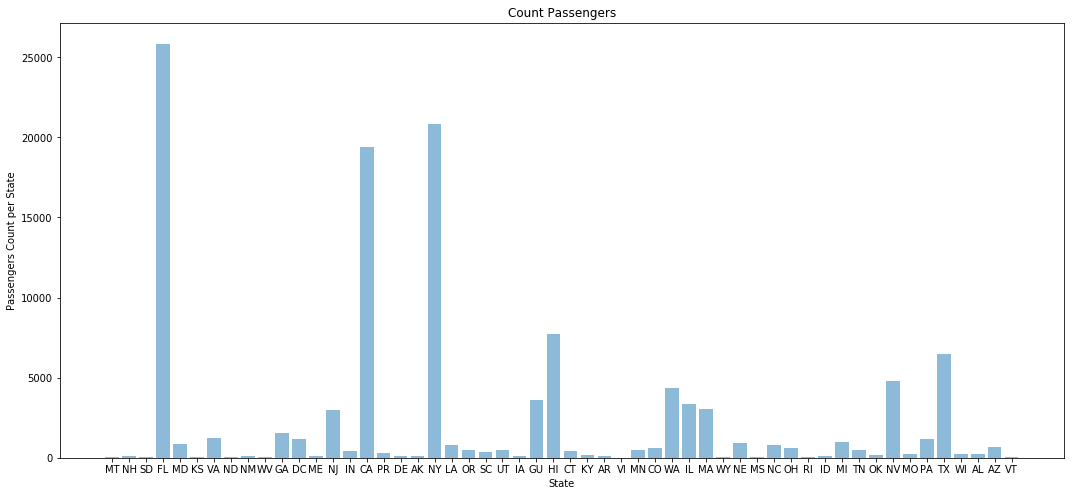

In [101]:
# Load Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = pipe.filter(pipe.arrdate == "2016-04-30").select("*").toPandas()

objects = data["i94addr"]
y_pos = np.arange(len(objects))
performance = data["count(count)"]
plt.figure(figsize=(18,8))

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel("Passengers Count per State")
plt.xlabel("State")
plt.title("Count Passengers")

plt.show()

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
        - Spark was choosen due the volume of the data, it couldn't be handle by pandas
* Propose how often the data should be updated and why.
        - The pipeline should run daily and the aggregation were done by day, so it is possible to consult the historic
* Write a description of how you would approach the problem differently under the following scenarios:
    - The data was increased by 100x
        - Spark can handle the increase the volume of the data
    - The data populates a dashboard that must be updated on a daily basis by 7am every day.
        - The pipeline can be schedule for any time
    - The database needed to be accessed by 100+ people.
        - The data is handled by spark can be saved on a redshift and accessed by 100+ people